<a href="https://colab.research.google.com/github/jiashenyue/dimensionality-reduction-2/blob/main/feature-engineering-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering for Bike Share Rental Model 

Shenyue Jia | [jiashenyue.info](https://jiashenyue.info)

In this notebook we use the following feature engineering strategies:

1. feature selection
2. removing outliers
3. log transformation
4. changing datatypes
5. scaling
6. binning
7. target encoding
8. polynomial features

In [157]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, \
precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay, \
classification_report

import warnings
warnings.filterwarnings('ignore')

# Useful Functions

In [158]:
def eval_regression(true, pred, name='Model'):
  scores = pd.DataFrame()
  scores['Model Name'] = [name]
  scores['RMSE'] = [np.sqrt(mean_squared_error(true, pred))]
  scores['MAE'] = [mean_absolute_error(true, pred)]
  scores['R2'] = [r2_score(true, pred)]
  return scores

def eval_classification(true, pred, name='Model'):
  """shows classification_report and confusion matrix
  for the model predictions"""
  
  print(name, '\n')
  print(classification_report(true, pred))
  ConfusionMatrixDisplay.from_predictions(true, pred)
  plt.show()

  scores = pd.DataFrame()
  scores['Model Name'] = [name]
  scores['Precision'] = [precision_score(true, pred)]
  scores['Recall'] = [recall_score(true, pred)]
  scores['F1 Score'] = [f1_score(true, pred)]
  scores['Accuracy'] = [accuracy_score(true, pred)]

  return scores

## Data

We will use the model to predict total number of bike share rentals during a given hour of the day.

Source of data: [this link](https://docs.google.com/spreadsheets/d/e/2PACX-1vROUXPkYUkX-2W7JbJ0-oNKaXzpg4NtmU9IeWEY6yFKm32ZEJOpRh_soHD4BeIcuHjYik3SEoXmkgwj/pub?output=csv)

In [159]:
# load data
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vROUXPkYUkX-2W7JbJ0-oNKaXzpg4NtmU9IeWEY6yFKm32ZEJOpRh_soHD4BeIcuHjYik3SEoXmkgwj/pub?output=csv')
df_backup = df.copy()

display(df.head())
print(df.shape)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 0:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 1:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 2:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 3:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 4:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


(10886, 12)


## Explore and clean the data
1. Drop the `casual` and `registered` columns as they are redundant to the target variable **`count`**
2. Transform `datetime` column into a datetime type and use it to create 3 new columns
  - Name of the Month
  - Name of the day of the Week
  - Hour of the day
2. Drop any duplicates
3. Look for missing values.  If you want to drop rows or columns, now is the time.  Wait on imputing until after the split.
4. Check summary statistics to look for outliers.

### Drop unnecessary columns

In [160]:
# drop 'Address' column
df.drop(columns=['casual','registered'], inplace=True)
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 0:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 1:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 2:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 3:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 4:00:00,1,0,0,1,9.84,14.395,75,0.0,1


### Create hour of the day columns

- Transform datetime column into a datetime type and use it to create 3 new columns
  1. Name of the Month
  2. Name of the day of the Week
  3. Hour of the day
    - Make sure all 3 new columns are 'object' datatype so they can be one-hot encoded later.

- Drop the `datetime` and `season` columns. These are now redundant.

In [161]:
# convert to datetime type
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df['datetime'].head()

0   2011-01-01 00:00:00
1   2011-01-01 01:00:00
2   2011-01-01 02:00:00
3   2011-01-01 03:00:00
4   2011-01-01 04:00:00
Name: datetime, dtype: datetime64[ns]

In [162]:
# create new columns
Month = df['datetime'].dt.strftime('%b').rename('Month')
DayofWeek = df['datetime'].dt.strftime('%a').rename('DayofWeek')
HourofDay = df['datetime'].dt.strftime('%H').rename('HourofDay')

In [163]:
# concatenate columns
df = pd.concat([df, Month, DayofWeek, HourofDay],axis=1)
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,Month,DayofWeek,HourofDay
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,Jan,Sat,00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,Jan,Sat,01
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,Jan,Sat,02
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,Jan,Sat,03
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,Jan,Sat,04


In [164]:
# drop `datetime` column
df.drop(columns=['datetime'], inplace=True)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,Month,DayofWeek,HourofDay
0,1,0,0,1,9.84,14.395,81,0.0,16,Jan,Sat,00
1,1,0,0,1,9.02,13.635,80,0.0,40,Jan,Sat,01
2,1,0,0,1,9.02,13.635,80,0.0,32,Jan,Sat,02
3,1,0,0,1,9.84,14.395,75,0.0,13,Jan,Sat,03
4,1,0,0,1,9.84,14.395,75,0.0,1,Jan,Sat,04


### Change `temp` to Fahrenheit

In [165]:
# apply the equation from Celsius to Fahrenheit 
df['temp'] = df['temp'] * 9/5 + 32
df['atemp'] = df['atemp'] * 9/5 + 32
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,Month,DayofWeek,HourofDay
0,1,0,0,1,49.712,57.911,81,0.0,16,Jan,Sat,00
1,1,0,0,1,48.236,56.543,80,0.0,40,Jan,Sat,01
2,1,0,0,1,48.236,56.543,80,0.0,32,Jan,Sat,02
3,1,0,0,1,49.712,57.911,75,0.0,13,Jan,Sat,03
4,1,0,0,1,49.712,57.911,75,0.0,1,Jan,Sat,04


### Create `temp_variance` column

- If `temp` > average, positive
- If `temp` < average, negative

In [166]:
# create temp_variance
avg_temp = df['temp'].mean()
# calculate the difference b/w temp and avg_temp
df['temp_variance'] = df['temp'] - avg_temp
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,Month,DayofWeek,HourofDay,temp_variance
0,1,0,0,1,49.712,57.911,81,0.0,16,Jan,Sat,00,-18.703548
1,1,0,0,1,48.236,56.543,80,0.0,40,Jan,Sat,01,-20.179548
2,1,0,0,1,48.236,56.543,80,0.0,32,Jan,Sat,02,-20.179548
3,1,0,0,1,49.712,57.911,75,0.0,13,Jan,Sat,03,-18.703548
4,1,0,0,1,49.712,57.911,75,0.0,1,Jan,Sat,04,-18.703548


In [167]:
# drop atemp column
df.drop(columns=['atemp'], inplace=True)
df.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,count,Month,DayofWeek,HourofDay,temp_variance
0,1,0,0,1,49.712,81,0.0,16,Jan,Sat,00,-18.703548
1,1,0,0,1,48.236,80,0.0,40,Jan,Sat,01,-20.179548
2,1,0,0,1,48.236,80,0.0,32,Jan,Sat,02,-20.179548
3,1,0,0,1,49.712,75,0.0,13,Jan,Sat,03,-18.703548
4,1,0,0,1,49.712,75,0.0,1,Jan,Sat,04,-18.703548


In [168]:
# check column types to make sure Dtype of newly added columns match 
# the requirement
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   season         10886 non-null  int64  
 1   holiday        10886 non-null  int64  
 2   workingday     10886 non-null  int64  
 3   weather        10886 non-null  int64  
 4   temp           10886 non-null  float64
 5   humidity       10886 non-null  int64  
 6   windspeed      10886 non-null  float64
 7   count          10886 non-null  int64  
 8   Month          10886 non-null  object 
 9   DayofWeek      10886 non-null  object 
 10  HourofDay      10886 non-null  object 
 11  temp_variance  10886 non-null  float64
dtypes: float64(3), int64(6), object(3)
memory usage: 1020.7+ KB


### Check duplicates and missing values

In [169]:
# check for duplicates
if df.duplicated().sum()>0:
  # drop duplicates
  print(f'Removed {df.duplicated().sum()} duplicated rows.')
  df.drop_duplicates()
else:
  print('There is no duplicated rows in the dataframe.')

Removed 1 duplicated rows.


In [170]:
# check for missing values
df.isna().sum()

season           0
holiday          0
workingday       0
weather          0
temp             0
humidity         0
windspeed        0
count            0
Month            0
DayofWeek        0
HourofDay        0
temp_variance    0
dtype: int64

In [171]:
# print unique values
cat_cols = ['season', 'holiday', 'workingday', 'weather']
for col in cat_cols:
    print(f'- {col}:')
    print(df[col].value_counts(dropna=False))
    print("\n\n")

- season:
4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64



- holiday:
0    10575
1      311
Name: holiday, dtype: int64



- workingday:
1    7412
0    3474
Name: workingday, dtype: int64



- weather:
1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64





- These columns may need to be further engineered to avoid introducing errors to our model

# Feature Engineering

What would you do to improve this dataset?

### Some Ideas:
1. Remove outliers
2. Change the distribution with np.log, np.sqrt, np.cbrt
3. Bin features or target with .replace or .apply
4. Combine features
5. Extract hour, day, or month from datetime
6. Encode data: one-hot encoding, ordinal encoding, target encoding
7. Parse strings
8. Try different imputation strategies

### Categorical Feature Engineering

Based on the unique values contained in each column, these columns should be converted from numeric to categorical type to avoid confusion and errors in the model:

- `season`
- `holiday`
- `workingday`
- `weather`

In [172]:
# convert numeric to categorical
df['season'] = df['season'].astype('object')
df['holiday'] = df['holiday'].astype('object')
df['workingday'] = df['workingday'].astype('object')
df['weather'] = df['weather'].astype('object')

## Datetime Feature Engineering

- Already converted `datetime` column into `Month`, `DayofWeek`, `HourofDay`

## Numeric Feature Engineering

### Filter to remove outliers


 temp 



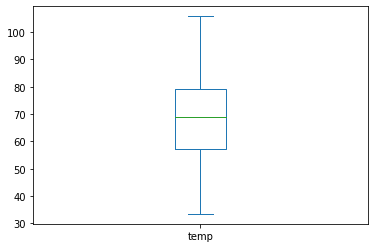


 humidity 



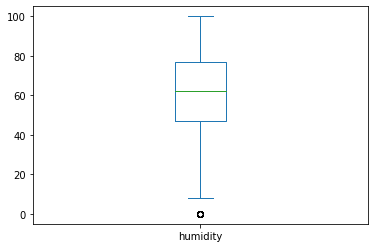


 windspeed 



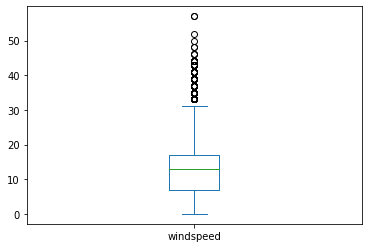


 count 



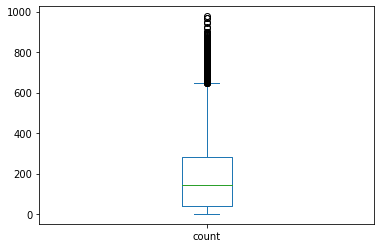


 temp_variance 



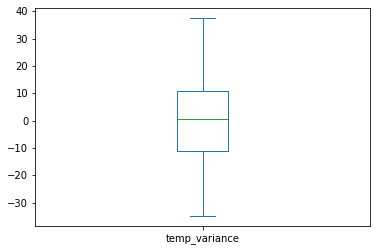

In [173]:
# explore numeric distributions
for col in df.select_dtypes('number'):
  print('\n', col, '\n')
  df[col].plot(kind='box')
  plt.show()

In [174]:
df['windspeed'].describe()

count    10886.000000
mean        12.799395
std          8.164537
min          0.000000
25%          7.001500
50%         12.998000
75%         16.997900
max         56.996900
Name: windspeed, dtype: float64

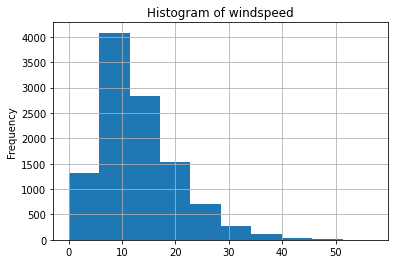

In [175]:
# plot histogram of the original windspeed column
df['windspeed'].plot(kind='hist')
plt.title('Histogram of windspeed')
plt.grid()

In [176]:
# exclude windspeed greater than 45
df = df[df['windspeed'] < 50]
df['windspeed'].describe()

count    10882.000000
mean        12.784251
std          8.127514
min          0.000000
25%          7.001500
50%         12.998000
75%         16.997900
max         47.998800
Name: windspeed, dtype: float64

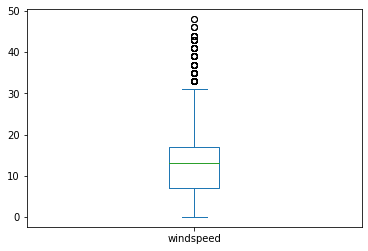

In [177]:
# plot the filtered df
df['windspeed'].plot(kind='box')

### Transform to normalize feature

- Normalize `temp` and `windspeed` columns
- `humidity` is already a value from 0 to 100% (a relative value); no need to further normalize

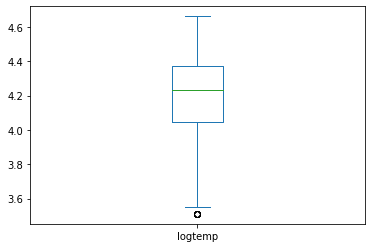

In [178]:
# log transform 'temp'
df['logtemp'] = np.log(df['temp'])
df['logtemp'].plot(kind='box')

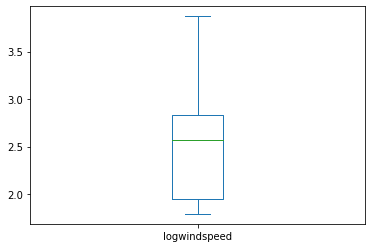

In [179]:
# log transform 'windspeed'
df['logwindspeed'] = np.log(df['windspeed'])
df['logwindspeed'].plot(kind='box')

In [180]:
eng_df = df.copy()
eng_df.drop(columns=['windspeed', 'temp'], inplace=True)

In [181]:
eng_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10882 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   season         10882 non-null  object 
 1   holiday        10882 non-null  object 
 2   workingday     10882 non-null  object 
 3   weather        10882 non-null  object 
 4   humidity       10882 non-null  int64  
 5   count          10882 non-null  int64  
 6   Month          10882 non-null  object 
 7   DayofWeek      10882 non-null  object 
 8   HourofDay      10882 non-null  object 
 9   temp_variance  10882 non-null  float64
 10  logtemp        10882 non-null  float64
 11  logwindspeed   10882 non-null  float64
dtypes: float64(3), int64(2), object(7)
memory usage: 1.1+ MB


# Validation Split

In [182]:
X = eng_df.drop(columns=['count'])
y = eng_df['count']

X_train, X_test, y_train, y_test =  train_test_split(X, y, random_state=42)

In [183]:
X_train.head()

,season,holiday,workingday,weather,humidity,Month,DayofWeek,HourofDay,temp_variance,logtemp,logwindspeed
2933,3,0,1,1,65,Jul,Mon,03,13.768452,4.408961,2.398023
7669,2,0,1,1,52,May,Fri,22,4.912452,4.294943,3.091170
1348,2,0,0,1,65,Apr,Sat,01,-17.227548,3.935505,2.197013
9432,3,0,0,1,60,Sep,Sun,09,6.388452,4.314871,2.197013
453,1,0,1,3,93,Feb,Tue,23,-21.655548,3.845028,2.564795


# Modeling: Base Model

In [184]:
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

median_imputer = SimpleImputer(strategy='median')
missing_imputer = SimpleImputer(strategy='constant', fill_value='missing')

cat_cols = make_column_selector(dtype_include='object')
num_cols = make_column_selector(dtype_include='number')

num_pipe = make_pipeline(median_imputer, scaler)
cat_pipe = make_pipeline(missing_imputer, ohe)

processor = make_column_transformer((num_pipe, num_cols), (cat_pipe, cat_cols))
print(processor.fit_transform(X_train, y_train).shape)

ValueError: ignored

In [ ]:
# Instantiate and fit model

scores = pd.DataFrame()

logreg2 = LogisticRegression()
log_pipe2 = make_pipeline(processor, logreg2)
log_pipe2.fit(X_train, y_train)

train_pred = log_pipe2.predict(X_train)
test_pred = log_pipe2.predict(X_test)

Train 

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      6302
           1       0.86      0.86      0.86      3882

    accuracy                           0.89     10184
   macro avg       0.89      0.89      0.89     10184
weighted avg       0.89      0.89      0.89     10184



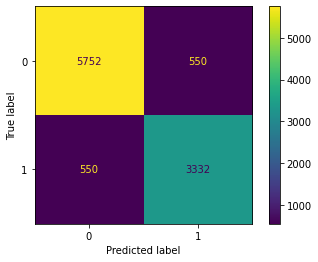

Test 

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      2036
           1       0.86      0.85      0.85      1359

    accuracy                           0.88      3395
   macro avg       0.88      0.88      0.88      3395
weighted avg       0.88      0.88      0.88      3395



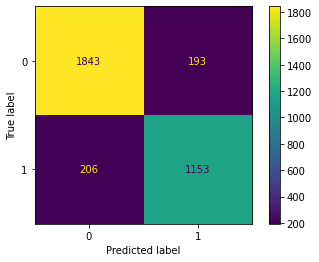

,Model Name,Precision,Recall,F1 Score,Accuracy
0,Train,0.858320,0.858320,0.858320,0.891987
0,Test,0.856612,0.848418,0.852495,0.882474


In [ ]:
# evaluate model
train_scores = eval_classification(y_train, train_pred, name='Train')

test_scores = eval_classification(y_test, test_pred, name='Test')

scores = pd.concat([train_scores, test_scores])
scores

# Modeling: PolynomialFeatures

## Test PolynomialFeatures to see how it changes data

We are working here with the entire dataframe to illustrate how the model combines numeric features.  We won't apply the transformers until later.

In [ ]:
# Create scaler and polynomial features
poly = PolynomialFeatures(degree=3)
scaler = StandardScaler()

# Scale the data
df_scaled = pd.DataFrame(scaler.fit_transform(df[['Lattitude','Longtitude']]), 
                            columns=df[['Lattitude','Longtitude']].columns)

poly_train = poly.fit_transform(df_scaled)
poly_train = pd.DataFrame(poly_train, columns=poly.get_feature_names_out())

poly_train.head()

,1,Lattitude,Longtitude,Lattitude^2,Lattitude Longtitude,Longtitude^2,Lattitude^3,Lattitude^2 Longtitude,Lattitude Longtitude^2,Longtitude^3
0,1.0,0.121166,0.030630,0.014681,0.003711,0.000938,1.778866e-03,4.496839e-04,1.136767e-04,2.873662e-05
1,1.0,0.016447,-0.017486,0.000271,-0.000288,0.000306,4.449071e-06,-4.730134e-06,5.028952e-06,-5.346648e-06
2,1.0,-0.001216,-0.007863,0.000001,0.000010,0.000062,-1.799480e-09,-1.163275e-08,-7.520007e-08,-4.861316e-07
3,1.0,0.155231,0.016195,0.024097,0.002514,0.000262,3.740570e-03,3.902487e-04,4.071412e-05,4.247650e-06
4,1.0,0.025279,-0.010750,0.000639,-0.000272,0.000116,1.615367e-05,-6.869393e-06,2.921228e-06,-1.242260e-06


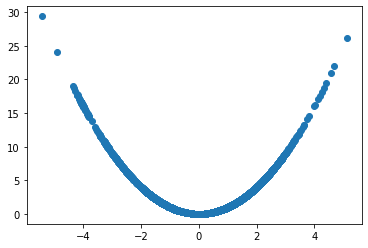

In [ ]:
# Plot distance vs distance^2
plt.scatter(data=poly_train, x='Longtitude', y='Longtitude^2')

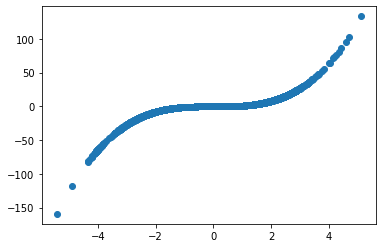

In [ ]:
plt.scatter(data=poly_train, x='Longtitude', y='Longtitude^3')

## Use PolynomialFeatures in a model pipeline

In [ ]:
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
poly = PolynomialFeatures(degree=2)

median_imputer = SimpleImputer(strategy='median')
missing_imputer = SimpleImputer(strategy='constant', fill_value='missing')

cat_cols = make_column_selector(dtype_include='object')
num_cols = make_column_selector(dtype_include='number')

num_pipe = make_pipeline(median_imputer, scaler, poly)
cat_pipe = make_pipeline(missing_imputer, ohe)

processor = make_column_transformer((num_pipe, num_cols), (cat_pipe, cat_cols))
print(processor.fit_transform(X_train, y_train).shape)

(10184, 329)


In [ ]:
# Instantiate and fit model with Polynomial Features

scores = pd.DataFrame()

logreg2 = LogisticRegression()
log_pipe2 = make_pipeline(processor, logreg2)
log_pipe2.fit(X_train, y_train)

train_pred = log_pipe2.predict(X_train)
test_pred = log_pipe2.predict(X_test)

Train 

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      6302
           1       0.87      0.87      0.87      3882

    accuracy                           0.90     10184
   macro avg       0.90      0.89      0.89     10184
weighted avg       0.90      0.90      0.90     10184



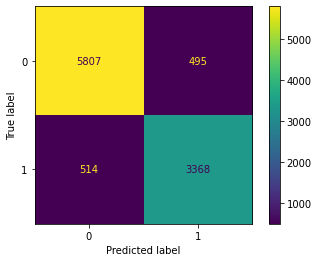

Test 

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2036
           1       0.87      0.86      0.86      1359

    accuracy                           0.89      3395
   macro avg       0.89      0.89      0.89      3395
weighted avg       0.89      0.89      0.89      3395



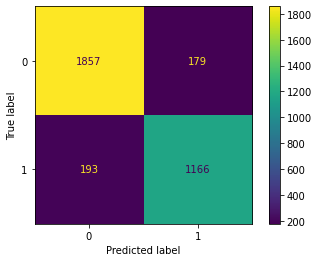

,Model Name,Precision,Recall,F1 Score,Accuracy
0,Train,0.871861,0.867594,0.869722,0.900923
0,Test,0.866914,0.857984,0.862426,0.890427


In [ ]:
# evaluate model
train_scores = eval_classification(y_train, train_pred, name='Train')

test_scores = eval_classification(y_test, test_pred, name='Test')

scores = pd.concat([train_scores, test_scores])
scores